# Customer Phone Plan Analysis

## Purpose

The purpose of this data analysis project is to which of the two prepaid phone plans is the most profitable. Data analyzed for this project consists of data from 500 customers during 2018.

## Table of Contents
<a href='#General Data Information'>General Data Information</a>

<a href='#Data Preprocessing'>Data Preprocessing</a>

<a href='#Hypothesis Testing'>Hypothesis Testing</a>

<a href='#Overall Conclusion'>Overall Conclusion</a>

<a id='General Data Information'></a>
## General Data Information

In [31]:
#import necessary modules and assign provided data sets to respective variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats as st
import seaborn as sns

calls_data = pd.read_csv('/datasets/megaline_calls.csv')
internet_data = pd.read_csv('/datasets/megaline_internet.csv')
messages_data = pd.read_csv('/datasets/megaline_messages.csv')
plans_data = pd.read_csv('/datasets/megaline_plans.csv')
users_data = pd.read_csv('/datasets/megaline_users.csv')

#Display general information for each of the available data sets
calls_data.info()
print('\n')
internet_data.info()
print('\n')
messages_data.info()
print('\n')
plans_data.info()
print('\n')
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data column

### Duplicate Check and Removal

In addition to a general look at the data sets, the data is checked for any duplicate entries.

In [32]:
#Create a list for each of the data frames
data = [calls_data, internet_data, messages_data, plans_data, users_data]

#check each data frame for duplicate entries
for entry in data:
    print('The total number of duplicated entries in attribute is {}'.format(entry.duplicated().sum()))

The total number of duplicated entries in attribute is 0
The total number of duplicated entries in attribute is 0
The total number of duplicated entries in attribute is 0
The total number of duplicated entries in attribute is 0
The total number of duplicated entries in attribute is 0


No duplicates exist.

### General Data Information Conclusion

The `users_data` provides general information on each of the 500 customers, including the plan they use, their location, starting subscription date, and ending subscription date (if applicable).

The `calls_data` provides the duration of every call made during 2018, including the customer that made it.

The `messages_data` provides data on each text message sent by every customer during 2018, including the date the message was sent.

The `internet_data` provides data on the internet usage for each customer, including the number of MB used during each session and the date of the session.

The `plans_data` provides general information on the two plans offered by Megaline. This information includes monthly fee, monthly minute, text, and internet data allowance, as well as the prices associated with each of these monthly limits.

From the initial look at the general information for each of the data frames, it appears that the only data frame that has any missing values is `user_data` in the `churn_date` column. In addition, there are several attributes that would benefit from changing data types such as all the attributes that correspond to dates. This will be addressed in the upcoming sections.

<a id='Data Preprocessing'></a>
## Data Preprocessing

Each of the data frames are preprocessed to change data types for certain attributes and for `users_data` to fill in missing values. Additionally, some of the data is modified to better prepare it for analyzing or to account for how Megaline determines monthly charges. 

### Data Type Conversion

**`calls_data`**

For the `calls_data`, two modifications are done:
- The `call_date` attribute is converted to datetime64 to allow it to be compared to other time-dependent attributes
- The `duration` of each individual call is rounded up to the nearest minute. This is done to be consistent with how treats each phone call duration 

In [33]:
#Converts call_date to datetime64
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'])
#Rounds each call duration up to the nearest minute
calls_data['duration'] = np.ceil(calls_data['duration'])

**`internet_data`**

For the time being, the only modification to `internet_data` is converting the `session_date` attribute to datetime64 to allow it to be compared to other time-dependent attributes. It is noted that Megaline rounds up the `mb_used` for each customer on a per month basis; however, that will be accounted for in a later section.

In [34]:
#Converts session_date to datetime64
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'])

**`messages_data`**

The only type conversion for `messages_data` is to convert `message_date` to datetime64 to allow it to be compared to other time-dependent attributes.

In [35]:
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'])

**`plans_data`**

`plans_data` does not require any type conversion.

**`users_data`**

`users_data` contains some attributes that require type conversion as well as missing values. The missing values are all in the `churn_date` attribute. Missing values likely exist since the customers that don't have a `churn_date` have not canceled their subscription. Since this project is evaluating the prepaid plans based on data from only 2018, the missing values in the `churn_date` can be replaced with the last day of 2018. For the purpose of this analysis, this addition will not affect any of the overall data. 

Once the missing values are replaced with the last day of the year, the `reg_date` and `churn_date` attributes can be converted to datetime64.

In [36]:
users_data['churn_date'].fillna('2018-12-31', inplace = True)

users_data['reg_date'] = pd.to_datetime(users_data['reg_date'])
users_data['churn_date'] = pd.to_datetime(users_data['churn_date'])

### Customer Monthly Reports

To better analyze the data and determine which prepaid plan is more profitable, the call, text, and internet data must be compiled into a per-month format as this will allow for the profit for each customer to be determined based on how much he or she exceeds their monthly allowances.

**`calls_data`**

For `calls_data`, the number of calls and the total duration of calls for each month must be compiled for each customer. From the `call_date` attribute, the month of each call is placed into a new column of the data frame, `month`. Now that each call has a distinct month that it occured in, a new data frame, `user_call_data_monthly` can be created that groups all the call data  by `user_id` for each calendar month. For each month, the total number of calls and the total minutes of calls is calculated and added to `user_call_data_monthly`.

In [37]:
#Creates new column with the month of the call
calls_data['month'] = calls_data['call_date'].dt.month

#Groups call_data by user_id and month and calculates the total number of calls and the total duration of calls for each month
user_call_data_monthly = calls_data.groupby(['user_id','month'], as_index = False).agg({'duration':['count','sum']})

#rename columns to better represent data
user_call_data_monthly.columns = ['user_id', 'month', 'number_of_calls', 'total_mins']

**`messages_data`**

For `messages_data`, the number of messages for each month must be compiled for each customer. From the `message_date` attribute, the month of each message is placed into a new column of the data frame, `month`. Now that each message has a distinct month that it occured in, a new data frame, `user_message_data_monthly` can be created that groups all the message data  by `user_id` for each calendar month. For each month, the total number of messages is calculated and added to the data frame.

In [38]:
#Creates new column with the month of the message
messages_data['month'] = messages_data['message_date'].dt.month

#Groups message_data by user_id and month and calculates the total number of messages for each month
user_message_data_monthly = messages_data.groupby(['user_id','month'], as_index = False).count()

#Deletes duplicated column from the .count() method and renames columns appropriately
del user_message_data_monthly['id']
user_message_data_monthly.columns = ['user_id', 'month','total_messages']

Since this new messages data frame is formated in the same manner as the data frame, `user_calls_data_monthly`, made for the call data for each customer, for each month, a single data frame can be made that combines the calls, messages, and internet data for each customer, for each month. This allows for all the relevant customer data to be in a single table.

In [39]:
#Merges the monthly call data with the monthly message data for each user
user_monthly_data = user_call_data_monthly.merge(user_message_data_monthly, on = ['user_id','month'], how = 'right')

**`internet_data`**

Similar to the calls and messages, for `internet_data`, the number of messages for each month must be compiled for each customer. However, additional work must be done for the monthly internet usage due to how Megaline accounts for the monthly internet usage.  

From the `session_date` attribute, the month of each internet session is placed into a new column of the data frame, `month`. Now that each session has a distinct month that it occured in, a new data frame, `user_internet_data_monthly` can be created that groups all the internet data  by `user_id` for each calendar month. For each month, the total number of megabytes used is calculated and added to the data frame. However, since Megaline rounds up the monthly internet bill to the nearest gigabyte, this must also be done to the data. A function is created to accomplish this and `mb_used` is converted to `total_gb`.

The resulting data is added to the `user_monthly_data` data frame.

In [40]:
#Creates new column with the month of the internet session
internet_data['month'] = internet_data['session_date'].dt.month

#Groups call_data by user_id and month and calculates the total number of calls and the total duration of calls for each month
user_internet_data_monthly = internet_data.groupby(['user_id','month'], as_index = False).agg({'mb_used':'sum'})

#This function takes the number of mb and rounds it up to the nearest gb
def GB_round(mb_used):
    gb = mb_used / 1024
    gb_round = np.ceil(gb)
    return gb_round
    
#Rounds mb_used up to the nearest GB
user_internet_data_monthly['mb_used'] = user_internet_data_monthly['mb_used'].apply(GB_round)
#Corrects column names after applying GB_round function
user_internet_data_monthly.columns = ['user_id','month','total_gb']

#Merges the monthly internet data with the other monthly message and call data for each user
user_monthly_data = user_monthly_data.merge(user_internet_data_monthly, on = ['user_id','month'], how = 'right')

#### Monthly Customer Profit

Monthly profit from each customer must be calculated in order to quantify which plan is providing the most profit. In order to do this, each user's plan must be added to the existing `user_monthly_data` in order to distinguish the amount of profit each customer contributes on a monthly basis. 

In [41]:
user_plan = users_data.pivot_table(index = 'user_id', values = 'plan', aggfunc = 'first')

user_monthly_data = user_monthly_data.merge(user_plan, on = 'user_id', how = 'right')

With each customer's plan added to the `user_monthly_data`, a `profit` attribute can be added to the data frame that calculates the amount of profit each customer's month results in. Profit is calculated via a function that takes in each month's `total_messages`, `total_gb`, `total_mins`.

In [42]:
#This function takes in four parameters from the user_monthly_data data frame. Since there a two plans, this function first checks
#to see which plan the user is on. Based on this, the extra minutes, gb, and messages over each plans allowance is determined
#These extra charges are then multiplied by the unit rate for the respective charge. The total of all these charges are summed
#in addition to the base monthly charge to the total_profit variable which is returned.
def monthly_profit(total_mins, total_messages, total_gb, plan):
    if plan == 'surf':
        extra_messages = total_messages - 50
        extra_internet = total_gb - 15
        extra_call = total_mins - 500
        if extra_messages > 0:
            message_profit = extra_messages*0.03
        else:
            message_profit = 0
        
        if extra_internet > 0:
            internet_profit = extra_internet*10
        else:
            internet_profit = 0
            
        if extra_call >0:
            call_profit = extra_call*0.03
        else:
            call_profit = 0
            
        total_profit = message_profit + internet_profit + call_profit + 20
        return total_profit
    else:
        extra_messages = total_messages - 1000
        extra_internet = total_gb - 30
        extra_call = total_mins - 3000
        if extra_messages > 0:
            message_profit = extra_messages*0.01
        else:
            message_profit = 0
        
        if extra_internet > 0:
            internet_profit = extra_internet*7
        else:
            internet_profit = 0
            
        if extra_call >0:
            call_profit = extra_call*0.01
        else:
            call_profit = 0
            
        total_profit = message_profit + internet_profit + call_profit + 70
        return total_profit

#Applies the monthly_profit function to the user_monthly_data data frame. Values in the total_mins, total_messages, total_gb, and plan
#columns are passed for each row.
user_monthly_data['profit'] = user_monthly_data.apply(lambda row: monthly_profit(row['total_mins'], row['total_messages'], row['total_gb'], row['plan']), axis =1)

### Customer Behavior

The `user_monthly_data` is now split into customer's that are on the "Surf" plan vs. the "Ultimate" plan in order to better understand how the customers of each plan spent their plan allowances on a monthly basis. The mean, variance, and standard deviation for `total_mins`, `total_messages`, and `total_gb` are calculated and compared. Histograms for each of these attributes are also created.

In [43]:
#Separates Ultimate and Surf customers into two separate data frames
ultimate_user_monthly_data = user_monthly_data.query('plan == "ultimate"')
surf_user_monthly_data = user_monthly_data.query('plan == "surf"')

key_parameters = ['total_mins', 'total_messages', 'total_gb', 'profit']

#### Ultimate Plan Data

In [44]:
#Calculates mean, variance, and std deviation for total monthly minutes
ultimate_mins_monthly_mean = ultimate_user_monthly_data['total_mins'].mean()
ultimate_mins_monthly_var = np.var(ultimate_user_monthly_data['total_mins'])
ultimate_mins_monthly_std = np.std(ultimate_user_monthly_data['total_mins'])

#Calculates mean, variance, and std deviation for total monthly messages
ultimate_msg_monthly_mean = ultimate_user_monthly_data['total_messages'].mean()
ultimate_msg_monthly_var = np.var(ultimate_user_monthly_data['total_messages'])
ultimate_msg_monthly_std = np.std(ultimate_user_monthly_data['total_messages'])

#Calculates mean, variance, and std deviation for total monthly internet volume
ultimate_gb_monthly_mean = ultimate_user_monthly_data['total_gb'].mean()
ultimate_gb_monthly_var = np.var(ultimate_user_monthly_data['total_gb'])
ultimate_gb_monthly_std = np.std(ultimate_user_monthly_data['total_gb'])

print('For users with the Ultimate Plan, the monthly mean, variance, and standard deviation for total minutes used are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(ultimate_mins_monthly_mean, ultimate_mins_monthly_var, ultimate_mins_monthly_std))
print('For messages, the monthly mean, variance, and standard deviation are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(ultimate_msg_monthly_mean, ultimate_msg_monthly_var, ultimate_msg_monthly_std))
print('For GB usage, the monthly mean, variance, and standard deviation are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(ultimate_gb_monthly_mean, ultimate_gb_monthly_var, ultimate_gb_monthly_std))

For users with the Ultimate Plan, the monthly mean, variance, and standard deviation for total minutes used are 442.51, 62180.82, and 249.36, respectively
For messages, the monthly mean, variance, and standard deviation are 46.37, 1081.81, and 32.89, respectively
For GB usage, the monthly mean, variance, and standard deviation are 17.33, 58.41, and 7.64, respectively


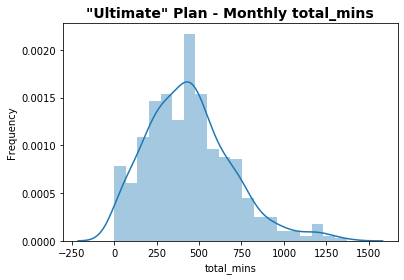

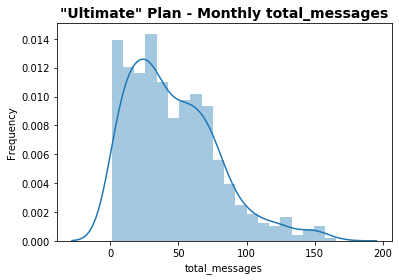

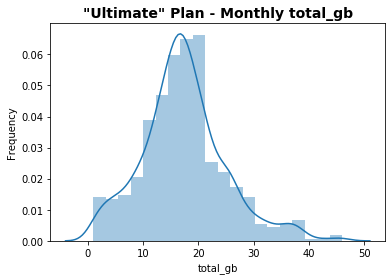

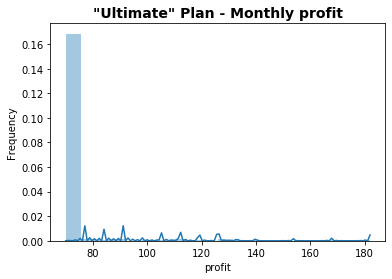

In [45]:
#Creates a density histogram for each of the parameters in the key parameters list
for index, i in enumerate(key_parameters):
    plt.figure(index)
    sns.distplot(ultimate_user_monthly_data[i], bins = 20)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('"Ultimate" Plan - Monthly {}'.format(i) , weight = 'bold', size =14)
    plt.show()  

In [46]:
#Calculates percentage of months that have greater than the monthly allowance of internet usage
internet_exceed_percentage = (len(ultimate_user_monthly_data.query('total_gb > 30')) / len(ultimate_user_monthly_data['month']))

print("Customer's exceed their monthly internet data allowance {:.2%} of the time".format(internet_exceed_percentage))

Customer's exceed their monthly internet data allowance 5.67% of the time


None of the monthly graphs for the "Ultimate" plan have any obvious outliers. A few of the potential high values could be evaluated further, namely the values at the far right of the `total_gb` histogram; however, the benefit is not considered worth it at this time for removal of only a few values. 

##### Ultimate Plan Conclusion

The monthly statistics for users with the "Ultimate" plan show the following:
- The majority of customer's monthly minute usage lies around the mean or within one standard deviation of the mean. There is a slight positive skew to the distribution with no significant outliers. None of the customer's exceed the monthly allowance resulting in no additional charges.
- Customer's monthly messages show a strong positive skew in the distribution, with a majority of the monthly messages being less than 75. None of the customer's exceed the monthly allowance resulting in no additional charges.
- Customer's monthly internet usage also shows a strong positive skew in the distribution with a large portion of the months located around the mean value. Unlike the minutes and messages, approximately 6% of months have customers that exceed the plan's allowance, resulting in additional charges.

A distribution histogram for monthly profit from each customer was also created. This histogram shows that nearly every month has a profit of less than \\$80, which shows that all the profit is primarily coming from the set \\$70 monthly fee as opposed to profits resulting from additional charges from customer's exceeding their monthly allowance.


#### Surf Plan Data

In [47]:
#Calculates mean, variance, and std deviation for total monthly minutes
surf_mins_monthly_mean = surf_user_monthly_data['total_mins'].mean()
surf_mins_monthly_var = np.var(surf_user_monthly_data['total_mins'])
surf_mins_monthly_std = np.std(surf_user_monthly_data['total_mins'])

#Calculates mean, variance, and std deviation for total monthly messages
surf_msg_monthly_mean = surf_user_monthly_data['total_messages'].mean()
surf_msg_monthly_var = np.var(surf_user_monthly_data['total_messages'])
surf_msg_monthly_std = np.std(surf_user_monthly_data['total_messages'])

#Calculates mean, variance, and std deviation for total monthly internet volume
surf_gb_monthly_mean = surf_user_monthly_data['total_gb'].mean()
surf_gb_monthly_var = np.var(surf_user_monthly_data['total_gb'])
surf_gb_monthly_std = np.std(surf_user_monthly_data['total_gb'])

print('For users with the Surf Plan, the monthly mean, variance, and standard deviation for total minutes used are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(surf_mins_monthly_mean, surf_mins_monthly_var, surf_mins_monthly_std))
print('For messages, the monthly mean, variance, and standard deviation are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(surf_msg_monthly_mean, surf_msg_monthly_var, surf_msg_monthly_std))
print('For GB usage, the monthly mean, variance, and standard deviation are {:.2f}, {:.2f}, and {:.2f}, respectively'.format(surf_gb_monthly_mean, surf_gb_monthly_var, surf_gb_monthly_std))

For users with the Surf Plan, the monthly mean, variance, and standard deviation for total minutes used are 445.78, 55274.53, and 235.11, respectively
For messages, the monthly mean, variance, and standard deviation are 39.63, 1034.51, and 32.16, respectively
For GB usage, the monthly mean, variance, and standard deviation are 16.83, 59.44, and 7.71, respectively


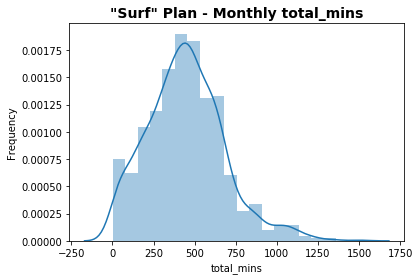

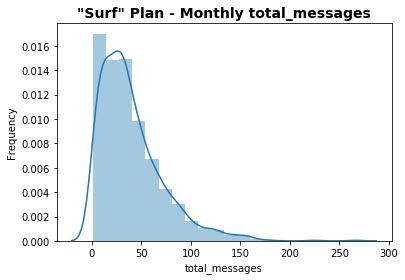

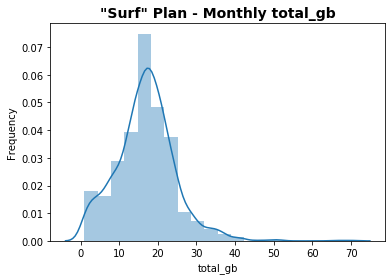

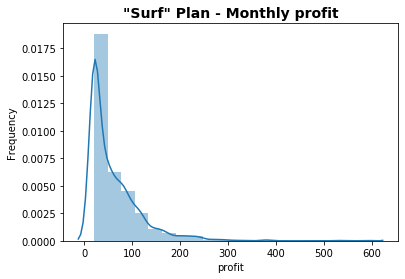

In [48]:
#Creates a density histogram for each of the parameters in the key parameters list
for index, i in enumerate(key_parameters):
    plt.figure(index)
    sns.distplot(surf_user_monthly_data[i], bins = 20)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('"Surf" Plan - Monthly {}'.format(i) , weight = 'bold', size =14)
    plt.show()  

In [49]:
#Calculates percentage of months that have greater than the monthly allowance for internet, call, and messages
minute_exceed_percentage = (len(surf_user_monthly_data.query('total_mins > 500')) / len(surf_user_monthly_data['month']))
message_exceed_percentage = (len(surf_user_monthly_data.query('total_messages > 50')) / len(surf_user_monthly_data['month']))
internet_exceed_percentage = (len(surf_user_monthly_data.query('total_gb > 15')) / len(surf_user_monthly_data['month']))

print("Customer's exceed their monthly minute allowance {:.2%} of the time, their message allowance {:.2%} of the time, and their internet data allowance {:.2%} of the time.".format(minute_exceed_percentage, message_exceed_percentage, internet_exceed_percentage))

Customer's exceed their monthly minute allowance 28.56% of the time, their message allowance 21.15% of the time, and their internet data allowance 58.21% of the time.


From the histograms, it is clear that the `total_messages` and `total_gb` have outliers that should be addressed to get an accurate representation of the data. For the `total_messages`, the upper limit for outliers will be set at 175 where the occurences of this value begin to disappear. For the `total_gb`, the upper limit for outliers will be set at 45 where the occurences of this value begin to disappear.

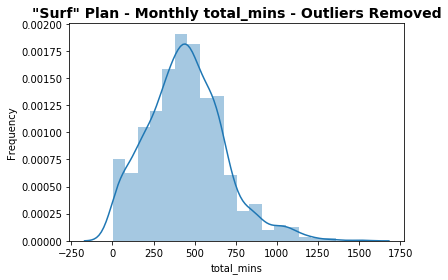

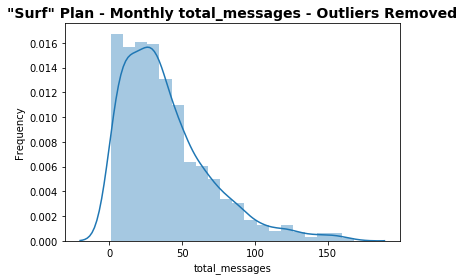

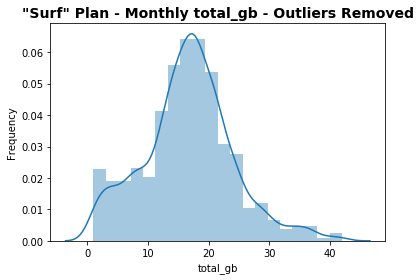

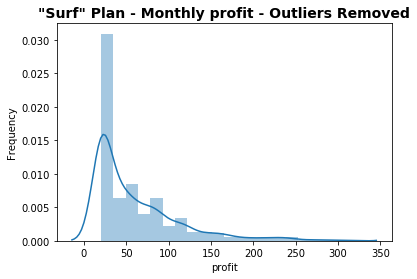

In [50]:
#Removes outliers in total_messages and total_gb
filtered_surf_user_monthly_data = surf_user_monthly_data.query('total_messages < 175 and total_gb < 45')

#Creates a density histogram for each of the parameters in the key parameters list
for index, i in enumerate(key_parameters):
    plt.figure(index)
    sns.distplot(filtered_surf_user_monthly_data[i], bins = 20)
    plt.xlabel(i)
    plt.ylabel('Frequency')
    plt.title('"Surf" Plan - Monthly {} - Outliers Removed'.format(i) , weight = 'bold', size =14)
    plt.show()  

With the outliers removed, the "Surf" plan can be better analyzed. Removing the outliers for the `total_messages` and `total_gb` removes some of the outliers for the profit as well. The distributions for the `total_messages` and `total_gb` with the outliers removed, for the most part, look the same as with the outliers; however, the distributions above the means for both of these are better defined.

##### Surf Plan Conclusion

The monthly statistics for users with the "Surf" plan show the following:
- The majority of customer's monthly minute usage lies around the mean or within one standard deviation of the mean. There is a slight positive skew to the distribution with no significant outliers, similar to the "Ultimate" plan. However, for the "Surf" plan, customers exceed their monthly minute allowance 29% of the time!
- Customer's monthly messages show a strong positive skew in the distribution. Unlike the "Ultimate" plan, customers exceed their monthly message allowance 21% of the time.
- Customer's monthly internet usage shows a slight positive skew in the distribution. Similar to the "Ultimate" plan, customers exceed their monthly allowance; however, this occurs much more frequently, with monthly overages occurring 58% of the time.

A distribution histogram for monthly profit from each customer was also created. As expected based on the significant number of monthly overages that occur, the monthly profits for the "Surf" plan are scattered about. Although the "Surf" plan has a lower monthly charge of \\$20, the significant number of additional charges from customers exceeding their monthly allowances may result in greater profit than the more expensive "Ultimate" plan. This will be further investigated in the following section.

<a id='Hypothesis Testing'></a>
## Hypothesis Testing

#### Ultimate vs. Surf Plan Profits

As discovered in the previous section, there is a huge difference between where the profits come from for the "Surf" plan vice the "Ultimate" plan in that the "Surf" plan makes a significant portion of profit from its additional monthly charges, whereas the "Ultimate" plan makes nearly all its profit from its base monthly fee. The hypothesis that these two marketing strategies result in different amounts of profit will be tested.

The null hypothesis is that there is no effect on profit as a result of the different marketing strategy for the two Megaline plans (i.e., the profits would be equal regardless of the plan). The alternative hypothesis would then be the opposite of the null; the difference in marketing strategies of "Surf" and "Ultimate" causes different amounts of profit. 

To test the hypothesis, the student t-test will be applied to the two samples of "Ultimate" and "Surf" plan customers, specifically the `profit` attribute as this is the best representation of how the profit differs between the two plans. The critical statistical significance level is set at 5\%. In order to accurately apply this method, the variances of both samples must first be compared:

In [51]:
#Compare variance of both samples. If variance is not close to being equal, equal_var = False in the ttest
print('Surf plan profit variance: {:.2f}'.format(np.var(filtered_surf_user_monthly_data['profit'])))
print('Ultimate plan profit variance: {:.2f}'.format(np.var(ultimate_user_monthly_data['profit'])))

Surf plan profit variance: 2630.76
Ultimate plan profit variance: 129.15


In [52]:
#Critical statistical significance level
alpha = 0.05

#Null hypothesis is there is no difference between profits
profit_results = st.ttest_ind(ultimate_user_monthly_data['profit'], filtered_surf_user_monthly_data['profit'], equal_var = False)

print('p-value: ', profit_results.pvalue)

if (profit_results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value:  1.5267961735902564e-15
We reject the null hypothesis


The null hypothesis that there is no difference in profit between the two plans can be rejected. There is in fact a difference in profits between the two plans, which can better be quantified by comparing the average profit of the two plans.

In [53]:
surf_mean_profit = filtered_surf_user_monthly_data['profit'].mean()
ultimate_mean_profit = ultimate_user_monthly_data['profit'].mean()

print('The Surf plan has an average monthly profit of ${:.2f}'.format(surf_mean_profit))
print('The Ultimate plan has an average monthly profit of ${:.2f}'.format(ultimate_mean_profit))

The Surf plan has an average monthly profit of $59.88
The Ultimate plan has an average monthly profit of $72.30


The "Ultimate" plan has a monthly profit that is approximately 20% higher than the "Surf" plan.

#### Location-based Profits

Another hypothesis that is being considered by Megalines is that the customers that live in the New Jersey - New York area have a differing monthly profit pull than in any other area of the United States, regardless of which plan they are in. This hypothesis will be tested.

The null hypothesis is that there is no difference in profit between customers in the New Jersey-New York area vs. customers in any other state. The alternative hypothesis is that there is in fact a difference in profit in these geographic locations.

Prior to testing this hypothesis, the `user_monthly_data` must be separated based on geographic location. Since this data frame does not contain the customer's location, this must first be added. Then the customers can be separated into two separate data frames: `ny_nj_customers` and `other_state_customers`.

In [54]:
#This function creates a new data frame attribute that groups users that live in NY or NJ into a 'yes' group and all others
#into a 'no' group
def location_group(city):
    if "NY" in city:
        return 'yes'
    elif "NJ" in city:
        return 'yes'
    else:
        return 'no'

#applies location_group function to every row in the users_data data frame
users_data['NY_NJ'] = users_data.apply(lambda row: location_group(row['city']), axis = 1)

user_location = users_data.pivot_table(index = 'user_id', values = 'NY_NJ', aggfunc = 'first')

#Merges user locations into main user_monthly_data data frame
user_monthly_data = user_monthly_data.merge(user_location, on='user_id', how='right')

#Separates all users into one of two groups based on location
ny_nj_customers = user_monthly_data.query('NY_NJ == "yes"')
other_state_customers = user_monthly_data.query('NY_NJ == "no"')

Now that the customers are separated based on location, the hypothesis can be tested. To test the hypothesis, the student t-test will be applied to the two samples of `ny_nj_customers` and `other_state_customers`, specifically the `profit` attribute as this is the best representation of how the profit differs between the two geographic locations. The critical statistical significance level is set at 5\%. In order to accurately apply this method, the variances of both samples must first be compared:

In [55]:
#Compare variance of both samples. If variance is not close to being equal, equal_var = False in the ttest
print('NY / NJ location profit variance: {:.2f}'.format(np.var(ny_nj_customers['profit'])))
print('Other US states location profit variance: {:.2f}'.format(np.var(other_state_customers['profit'])))

NY / NJ location profit variance: 2098.01
Other US states location profit variance: 2182.24


In [56]:
#Critical statistical significance level
alpha = 0.05

#Null hypothesis is there is no difference between profits at different locations
location_profit_results = st.ttest_ind(ny_nj_customers['profit'], other_state_customers['profit'], equal_var = True)

print('p-value: ', location_profit_results.pvalue)

if (location_profit_results.pvalue < alpha):
    print('We reject the null hypothesis')
else:
    print("We can't reject the null hypothesis")

p-value:  0.0955500171277218
We can't reject the null hypothesis


The null hypothesis that there is no difference in profit between the states of New York / New Jersey and the rest of the United States cannot be rejected. The p-value is 0.09 which is close to the critical statistical significance level, but not enough to disprove the null hypothesis. It is quite possible that there is not a difference in profits between the aforementioned geographic locations as supported by the relatively close mean profits between the two samples.

<a id='Overall Conclusion'></a>
## Overall Conclusion

The purpose of this project was to determine which of the two plans offered by Megaline, "Ultimate" and "Surf" was more profitable in order to recommend to Megaline which plan should receive the focus of the advertising budget.

Customer data from 2018 was provided for the two plans offered. This data was preprocessed by filling in missing values, changing data types, and adding in the total profit on a monthly basis for each customer.

Various histograms were created and compared for the monthly numbers of call minutes, messages sent, and internet volume used by each customer. Based on these histograms, it was determined that customers on the "Ultimate" plan had a consistent monthly profit with little variance. This was due to the high allowances offered by the "Ultimate" plan that meant customers never exceeded their monthly allowance on calls or messages, and rarely exceeded their monthly allowance on internet data, resulting in few additional charges outside of the base monthly fee. On the other hand, the "Surf" plan had varied profits since customers frequently exceeded their monthly allowances and had to pay additional charges. 

As a result of these differences between the plans, it was hypothesized that there might be a difference in the overall profit from each plan. The null hypothesis that there was no difference in profit between the plans was tested via a Student t-test and was subsequently rejected, showing that there is a difference in profit between the two plans. Although the "Surf" plan had a larger variance of profits, including sometimes resulting in profit much higher than the average profit of the "Ultimate" plan, the high base cost of the "Ultimate" plan proves to be more reliable, resulting in the greatest profit.

It was also hypothesized that profit coming from customers in the states of New York and New Jersey might differ compared to other states; however, there was not enough data to support this hypothesis.

Megaline should focus their advertising budget on promoting the "Ultimate" plan in order to get more customers that choose this plan.